In [1]:
%matplotlib inline

In [2]:
# Copyright (c) 2016,2019 MetPy Developers.
# Distributed under the terms of the BSD 3-Clause License.
# SPDX-License-Identifier: BSD-3-Clause

# Inverse Distance Verification: Cressman and Barnes

Compare inverse distance interpolation methods

Two popular interpolation schemes that use inverse distance weighting of observations are the
Barnes and Cressman analyses. The Cressman analysis is relatively straightforward and uses
the ratio between distance of an observation from a grid cell and the maximum allowable
distance to calculate the relative importance of an observation for calculating an
interpolation value.  Barnes uses the inverse exponential ratio of each distance between
an observation and a grid cell and the average spacing of the observations over the domain.

Algorithmically:

1. A KDTree data structure is built using the locations of each observation.
2. All observations within a maximum allowable distance of a particular grid cell are found in
   O(log n) time.
3. Using the weighting rules for Cressman or Barnes analyses, the observations are given a
   proportional value, primarily based on their distance from the grid cell.
4. The sum of these proportional values is calculated and this value is used as the
   interpolated value.
5. Steps 2 through 4 are repeated for each grid cell.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import cKDTree

from metpy.interpolate.geometry import dist_2
from metpy.interpolate.points import barnes_point, cressman_point
from metpy.interpolate.tools import average_spacing, calc_kappa


def draw_circle(ax, x, y, r, m, label):
    th = np.linspace(0, 2 * np.pi, 100)
    nx = x + r * np.cos(th)
    ny = y + r * np.sin(th)
    ax.plot(nx, ny, m, label=label)


Generate random x and y coordinates, and observation values proportional to x * y.

Set up two test grid locations at (30, 30) and (60, 60).

In [4]:
pts = np.array([[8, 24], [67, 87], [79, 48], [10, 94], [52, 98],
                [53, 66], [98, 14], [34, 24], [15, 60], [58, 16]])
xp = pts[:, 0]
yp = pts[:, 1]
zp = xp**2 / 1000

sim_gridx = [30, 60]
sim_gridy = [30, 60]

Set up a cKDTree object and query all the observations within "radius" of each grid point.

The variable ``indices`` represents the index of each matched coordinate within the
cKDTree's ``data`` list.

In [5]:
grid_points = np.array(list(zip(sim_gridx, sim_gridy, strict=False)))

radius = 40
obs_tree = cKDTree(list(zip(xp, yp, strict=False)))
indices = obs_tree.query_ball_point(grid_points, r=radius)

For grid 0, we will use Cressman to interpolate its value.

In [6]:
x1, y1 = obs_tree.data[indices[0]].T
cress_dist = dist_2(sim_gridx[0], sim_gridy[0], x1, y1)
cress_obs = zp[indices[0]]

cress_val = cressman_point(cress_dist, cress_obs, radius)

For grid 1, we will use barnes to interpolate its value.

We need to calculate kappa--the average distance between observations over the domain.

In [7]:
x2, y2 = obs_tree.data[indices[1]].T
barnes_dist = dist_2(sim_gridx[1], sim_gridy[1], x2, y2)
barnes_obs = zp[indices[1]]

kappa = calc_kappa(average_spacing(list(zip(xp, yp, strict=False))))

barnes_val = barnes_point(barnes_dist, barnes_obs, kappa)

Plot all of the affiliated information and interpolation values.

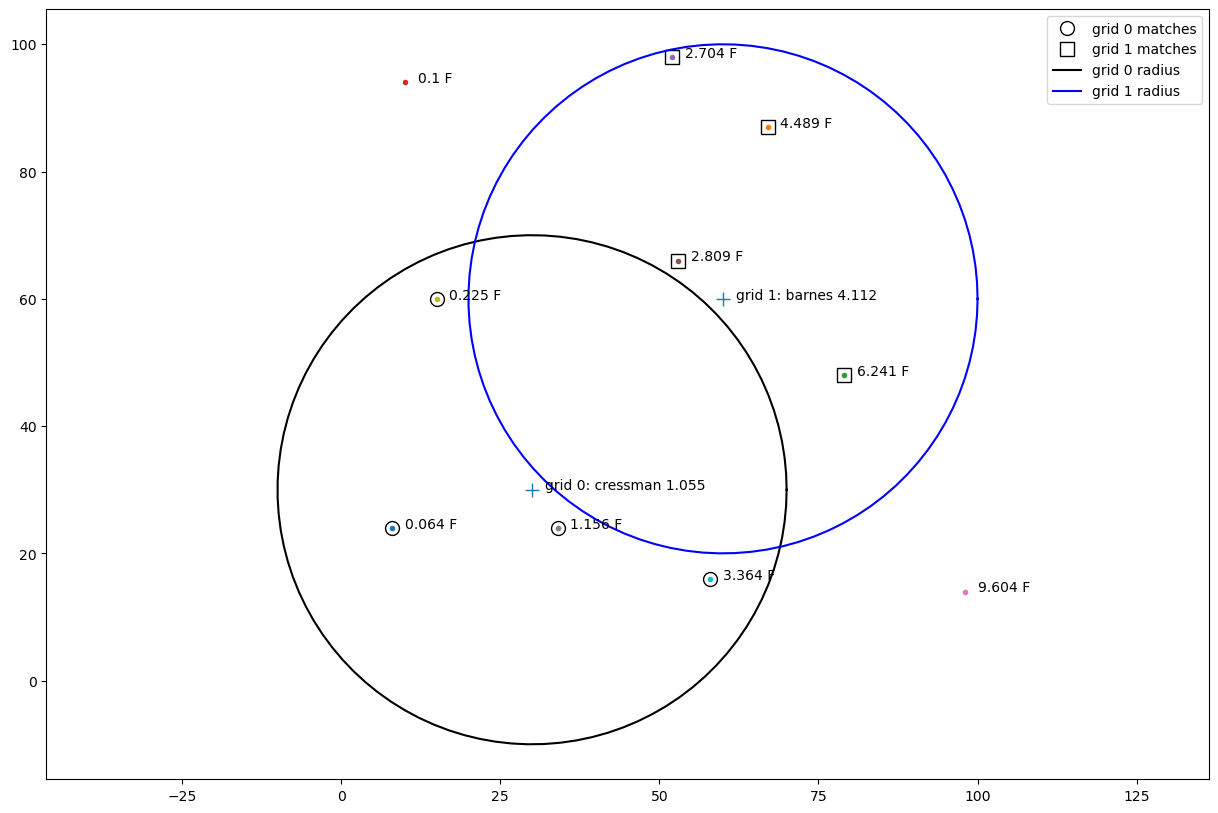

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
for i, zval in enumerate(zp):
    ax.plot(pts[i, 0], pts[i, 1], '.')
    ax.annotate(str(zval) + ' F', xy=(pts[i, 0] + 2, pts[i, 1]))

ax.plot(sim_gridx, sim_gridy, '+', markersize=10)

ax.plot(x1, y1, 'ko', fillstyle='none', markersize=10, label='grid 0 matches')
ax.plot(x2, y2, 'ks', fillstyle='none', markersize=10, label='grid 1 matches')

draw_circle(ax, sim_gridx[0], sim_gridy[0], m='k-', r=radius, label='grid 0 radius')
draw_circle(ax, sim_gridx[1], sim_gridy[1], m='b-', r=radius, label='grid 1 radius')

ax.annotate(f'grid 0: cressman {cress_val:.3f}', xy=(sim_gridx[0] + 2, sim_gridy[0]))
ax.annotate(f'grid 1: barnes {barnes_val:.3f}', xy=(sim_gridx[1] + 2, sim_gridy[1]))

ax.set_aspect('equal', 'datalim')
ax.legend()

For each point, we will do a manual check of the interpolation values by doing a step by
step and visual breakdown.

Plot the grid point, observations within radius of the grid point, their locations, and
their distances from the grid point.

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


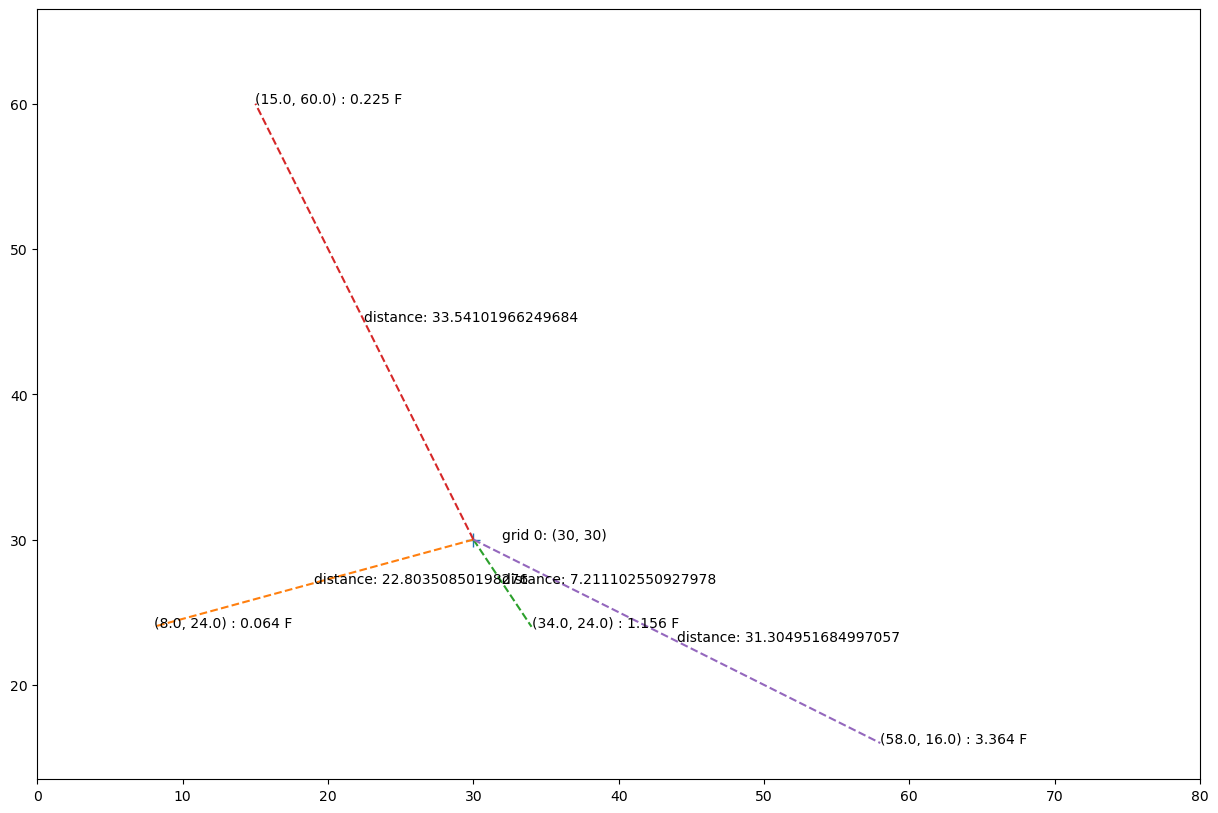

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.annotate(f'grid 0: ({sim_gridx[0]}, {sim_gridy[0]})', xy=(sim_gridx[0] + 2, sim_gridy[0]))
ax.plot(sim_gridx[0], sim_gridy[0], '+', markersize=10)

mx, my = obs_tree.data[indices[0]].T
mz = zp[indices[0]]

for x, y, z in zip(mx, my, mz, strict=False):
    d = np.sqrt((sim_gridx[0] - x)**2 + (y - sim_gridy[0])**2)
    ax.plot([sim_gridx[0], x], [sim_gridy[0], y], '--')

    xave = np.mean([sim_gridx[0], x])
    yave = np.mean([sim_gridy[0], y])

    ax.annotate(f'distance: {d}', xy=(xave, yave))
    ax.annotate(f'({x}, {y}) : {z} F', xy=(x, y))

ax.set_xlim(0, 80)
ax.set_ylim(0, 80)
ax.set_aspect('equal', 'datalim')

Step through the Cressman calculations.

In [10]:
dists = np.array([22.803508502, 7.21110255093, 31.304951685, 33.5410196625])
values = np.array([0.064, 1.156, 3.364, 0.225])

cres_weights = (radius**2 - dists**2) / (radius**2 + dists**2)
total_weights = np.sum(cres_weights)
proportion = cres_weights / total_weights
value = values * proportion

val = cressman_point(cress_dist, cress_obs, radius)

print('Manual cressman value for grid 1:\t', np.sum(value))
print('Metpy cressman value for grid 1:\t', val)

Manual cressman value for grid 1:	 1.0549944440419021
Metpy cressman value for grid 1:	 1.0549944440416752


Now repeat for grid 1, except use Barnes interpolation.

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


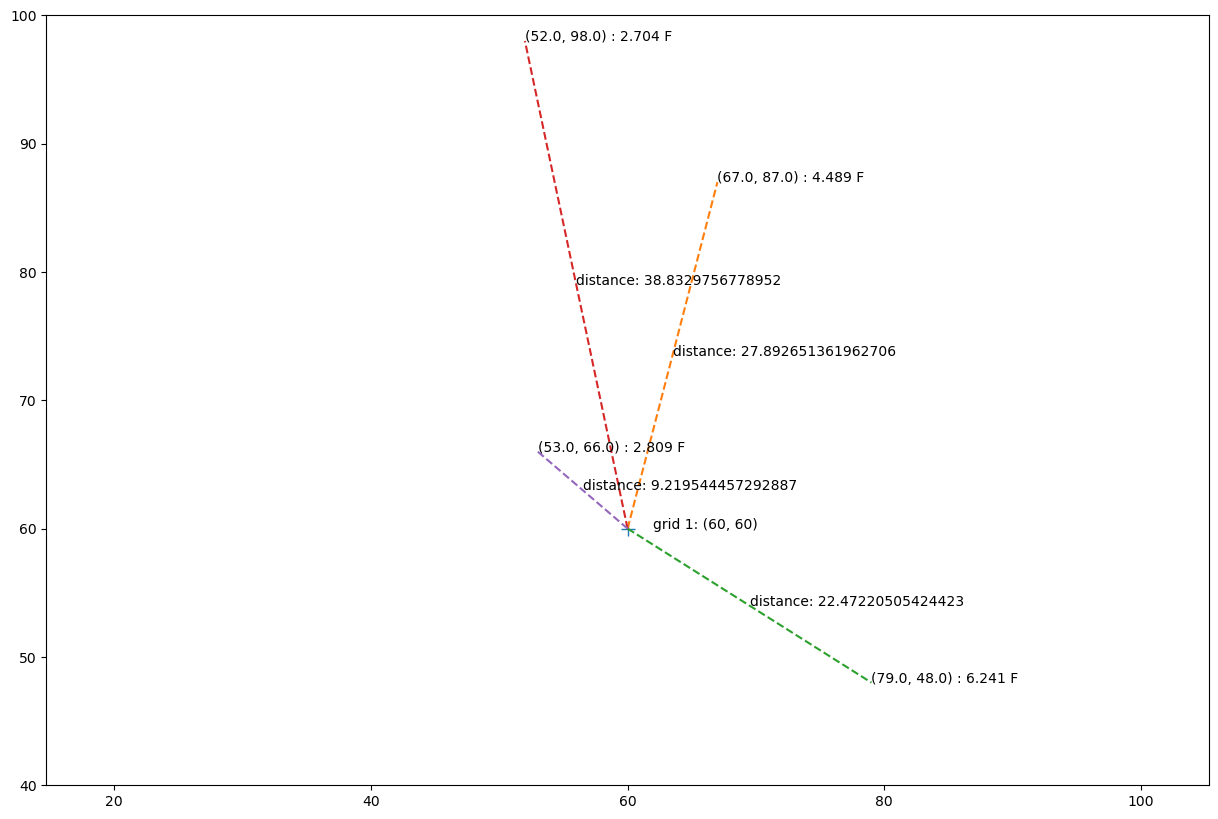

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.annotate(f'grid 1: ({sim_gridx[1]}, {sim_gridy[1]})', xy=(sim_gridx[1] + 2, sim_gridy[1]))
ax.plot(sim_gridx[1], sim_gridy[1], '+', markersize=10)

mx, my = obs_tree.data[indices[1]].T
mz = zp[indices[1]]

for x, y, z in zip(mx, my, mz, strict=False):
    d = np.sqrt((sim_gridx[1] - x)**2 + (y - sim_gridy[1])**2)
    ax.plot([sim_gridx[1], x], [sim_gridy[1], y], '--')

    xave = np.mean([sim_gridx[1], x])
    yave = np.mean([sim_gridy[1], y])

    ax.annotate(f'distance: {d}', xy=(xave, yave))
    ax.annotate(f'({x}, {y}) : {z} F', xy=(x, y))

ax.set_xlim(40, 80)
ax.set_ylim(40, 100)
ax.set_aspect('equal', 'datalim')

Step through barnes calculations.

In [12]:
dists = np.array([9.21954445729, 22.4722050542, 27.892651362, 38.8329756779])
values = np.array([2.809, 6.241, 4.489, 2.704])

weights = np.exp(-dists**2 / kappa)
total_weights = np.sum(weights)
value = np.sum(values * (weights / total_weights))

print('Manual barnes value:\t', value)
print('Metpy barnes value:\t', barnes_point(barnes_dist, barnes_obs, kappa))

plt.show()

Manual barnes value:	 4.112066483189193
Metpy barnes value:	 4.112066483188547
